In [1]:
import pandas as pd
from joblib import Memory
from datetime import datetime
memory = Memory(f"cachedir/{datetime.today().date()}", compress=True)

@memory.cache
def cached_read(url):
    return pd.read_csv(url)

In [2]:
df = cached_read("https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/blob/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv?raw=true")
plz = (14612, )
df = df[df.IdLandkreis == 14612]
df

________________________________________________________________________________
[Memory] Calling __main__--tmp-ipykernel-4239711195.cached_read...
cached_read('https://github.com/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/blob/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv?raw=true')
_____________________________________________________cached_read - 51.9s, 0.9min


,IdLandkreis,Altersgruppe,Geschlecht,Meldedatum,Refdatum,IstErkrankungsbeginn,NeuerFall,NeuerTodesfall,NeuGenesen,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
4507698,14612,A80+,M,2021-01-04,2020-01-04,1,0,0,-9,1,1,0
4507699,14612,A15-A34,M,2022-01-13,2020-01-09,1,0,-9,0,1,0,1
4507700,14612,A35-A59,M,2022-01-28,2020-01-27,1,0,-9,0,1,0,1
4507701,14612,A60-A79,M,2021-02-10,2020-02-03,1,0,-9,0,1,0,1
4507702,14612,A35-A59,M,2020-03-13,2020-02-25,1,0,-9,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4537207,14612,A15-A34,W,2022-05-20,2022-05-20,0,0,-9,-9,2,0,0
4537208,14612,A35-A59,W,2022-05-20,2022-05-20,0,0,-9,-9,2,0,0
4537209,14612,A80+,W,2022-05-20,2022-05-20,0,0,-9,-9,2,0,0
4537210,14612,A60-A79,W,2022-05-20,2022-05-20,0,0,-9,-9,1,0,0


,rki_7days,rki_14days,rki_28days
Refdatum,,,
2020-01-03,0.178253,1.247772,1.247772
2020-01-04,0.534759,1.871658,1.871658
2020-01-09,0.891266,2.079620,2.079620
2020-01-18,1.069519,1.871658,1.871658
2020-01-27,1.247772,1.746881,1.746881
...,...,...,...
2022-05-17,282.174688,317.290553,482.085561
2022-05-18,264.884135,304.367201,453.921569
2022-05-19,249.910873,287.611408,426.069519


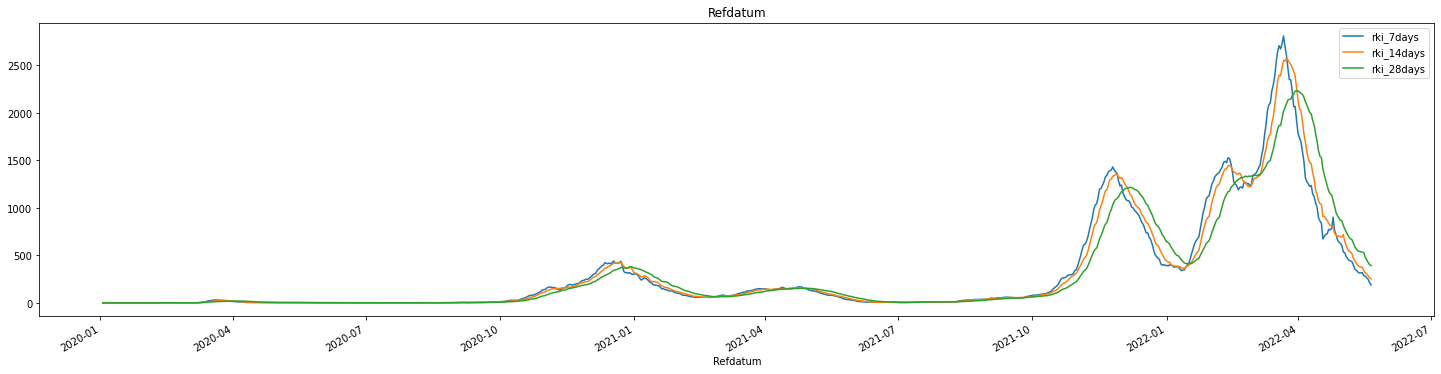

In [3]:
group = df.groupby("Refdatum").sum().filter(("AnzahlFall",)).interpolate()
df_out = group.rolling(7, min_periods=1).sum().rename(columns={"AnzahlFall": "rki_7days"})
df_out["rki_14days"] = group.rolling(14, min_periods=1).mean() * 7
df_out["rki_28days"] = group.rolling(28, min_periods=1).mean() * 7

df_out = df_out / 5.61
# df_out = df_out.pivot_table(index="Refdatum", columns="Altersgruppe")
df_out.index = pd.to_datetime(df_out.index)
df_out = df_out.interpolate("time", axis=0).fillna(0)
# df_out.columns = [' '.join(col).strip() for col in df_out.columns.values]
df_out.plot(figsize=(25,6), title="Refdatum")
df_out

In [4]:
df_out.to_csv("Dresden_RKI_data.csv")

# Compare

In [5]:
# compare
df_cmp = (
    pd.read_csv(
        "~/user/Downloads/sqllab_query_dispense_luaabwasser_lua_20220317T205021.csv"
    )
    .set_index("meldedatum")
    .rename(
        columns={"sieben_days_inz_100k": "lua_7days", "rki_7days_inz": "rki_7days_bisher"}
    )
)
df.groupby("Refdatum").sum().filter(("AnzahlFall",)).rolling(
    7, min_periods=1
).sum().rename(columns={"AnzahlFall": "rki_7days_github"}).apply(lambda x: x / 5.61).join(
    df_cmp, rsuffix="2"
).filter(
    ("rki_7days_github", "lua_7days", "rki_7days_bisher")
).dropna().plot(
    figsize=(15, 6)
)


FileNotFoundError: [Errno 2] No such file or directory: '/home/martin/user/Downloads/sqllab_query_dispense_luaabwasser_lua_20220317T205021.csv'